In [9]:
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
import japanize_matplotlib
# import matplotlib as plt

# ===============================================================
# 関数定義
# ===============================================================
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    margin = t_value * std / np.sqrt(n)
    return mean - margin, mean + margin

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理スキップ")
        return df

    print("欠損処理中...")
    processed_groups = []
    for race_id, group in df.groupby("race_id"):
        non_missing_mask = group[features].notnull().all(axis=1)
        if non_missing_mask.sum() < min_horses:
            continue
        for col in features:
            if group[col].isnull().any():
                group[col] = group[col].fillna(group[col].mean(skipna=True))
        processed_groups.append(group)
    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"処理後: {len(df_processed)}件（元:{len(df)}）")
    return df_processed

def get_last_corner_position(row):
    for i in [4, 3, 2, 1]:
        val = row.get(f"position_{i}")
        if pd.notnull(val):
            return val
    return np.nan

# ===============================================================
# データ読み込み
# ===============================================================
num_horses = 12
target_course_ids = [602]
# target_course_ids = 202
course_label = "_".join(map(str, target_course_ids))
input_file = "input_全頭_編集後.csv"
df_all = pd.read_csv(input_file, encoding="utf-8")
df_all["race_date"] = pd.to_datetime(df_all["race_date"])
print(f"全データ: {len(df_all)}件")

# 並び替え
df_all = df_all.sort_values(["race_id", "horse_number"])

# ===============================================================
# ランニングスタイル判定（全期間・過去出走ベース）
# ===============================================================

print("🏇 ランニングスタイル（過去出走ベース）を算出中...")

# 最終コーナー順位を取得
df_all["last_corner_position"] = df_all.apply(get_last_corner_position, axis=1)
df_all["last_corner_position_rate"] = (
    df_all["last_corner_position"] / df_all["num_horses"]
)

# race_date順にソート（時系列処理のため）
df_all = df_all.sort_values(["horse_id", "race_date"]).reset_index(drop=True)

# 各馬について、各レース時点での「それ以前の平均通過順位率」を計算
def calc_past_avg(x):
    return x.expanding().mean().shift()

df_all["avg_last_corner_pos_rate_past"] = (
    df_all.groupby("horse_id", group_keys=False)["last_corner_position_rate"]
    .transform(calc_past_avg)
)

# 0.5未満なら「front」、以上なら「back」
df_all["running_style_type_past"] = np.where(
    df_all["avg_last_corner_pos_rate_past"] < 0.5, "front",
    np.where(df_all["avg_last_corner_pos_rate_past"].notnull(), "back", np.nan)
)

# ===============================================================
# 指定頭数×コースの分析対象データに絞る
# ===============================================================
df_target = df_all[
    (df_all["num_horses"] == num_horses) &
    (df_all["course_id"].isin(target_course_ids))
].copy()

# 欠損値処理
handle_missing = True
min_non_missing_horses = num_horses
missing_check_features = ["time_index_average_2", "jockey_place_rate_100"]

df_target = handle_missing_val(
    df_target,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)

# ===============================================================
# 特徴量作成
# ===============================================================

# (1) タイム指数平均との差
race_avg_time_index = df_target.groupby("race_id")["time_index_average_2"].transform("mean")
df_target["time_index_diff_from_avg"] = df_target["time_index_average_2"] - race_avg_time_index

# (2) 騎手勝率平均との差
race_avg_jockey_place_rate = df_target.groupby("race_id")["jockey_place_rate_100"].transform("mean")
df_target["jockey_place_rate_diff_from_avg"] = (
    df_target["jockey_place_rate_100"] - race_avg_jockey_place_rate
)

# (3) 馬番別勝率（指定コース×頭数）
df_target["is_win"] = (df_target["finish_rank"] == 1).astype(int)
win_rate_by_horse_number = (
    df_target.groupby(["course_id", "horse_number"])["is_win"]
    .mean()
    .reset_index()
    .rename(columns={"is_win": "win_rate_by_course_horse_number"})
)
df_target = df_target.merge(
    win_rate_by_horse_number,
    on=["course_id", "horse_number"],
    how="left"
)

# (4) ランニングスタイル別勝率（指定コース×頭数×ランニングスタイル）
'''
course_style_win_prob = (
    df_target.groupby(["course_id", "running_style_type_past"])["is_win"]
    .mean()
    .reset_index()
    .rename(columns={"is_win": "running_style_win_prob"})
)
df_target = df_target.merge(
    course_style_win_prob,
    on=["course_id", "running_style_type_past"],
    how="left"
)
'''
# 各馬ごとに全期間の平均通過順位率を算出
horse_mean_style_rate = (
    df_all.groupby("horse_id")["last_corner_position_rate"]
    .mean()
    .reset_index()
    .rename(columns={"last_corner_position_rate": "mean_last_corner_pos_rate_all"})
)
# スタイルを固定的に分類（全期間平均ベース）
horse_mean_style_rate["running_style_type_overall"] = np.where(
    horse_mean_style_rate["mean_last_corner_pos_rate_all"] < 0.5, "front", "back"
)
# 指定コースのみを抽出
df_course = df_all[df_all["course_id"].isin(target_course_ids)].copy()

# 各馬の固定スタイル（全期間平均ベース）を付与
df_course = df_course.merge(
    horse_mean_style_rate[["horse_id", "running_style_type_overall"]],
    on="horse_id",
    how="left"
)

# コース × front/back ごとに勝率を算出
course_style_win_summary_target = (
    df_course.groupby(["course_id", "running_style_type_overall"])
    .agg(
        total_runs=("horse_id", "count"),                    # 出走数（分母）
        total_wins=("finish_rank", lambda x: (x == 1).sum()) # 勝利数（分子）
    )
    .reset_index()
)

# 勝率を計算
course_style_win_summary_target["win_rate_overall"] = (
    course_style_win_summary_target["total_wins"] / course_style_win_summary_target["total_runs"]
)
# 出力
print("✅ 指定コースごとの front/back 勝率を算出しました。")
print(course_style_win_summary_target)
print("🏇 df_target にコース別 front/back 全期間勝率を結合中...")
# course_style_win_summary_target には
# ["course_id", "running_style_type_overall", "win_rate_overall"] が含まれている前提
df_target = df_target.merge(
    course_style_win_summary_target[["course_id", "running_style_type_overall", "win_rate_overall"]],
    left_on=["course_id", "running_style_type_past"],
    right_on=["course_id", "running_style_type_overall"],
    how="left"
)
# 不要なカラムを整理
df_target = df_target.drop(columns=["running_style_type_overall"])
# カラム名をわかりやすくリネーム
df_target = df_target.rename(columns={
    "win_rate_overall": "running_style_win_prob"
})
# 出力
print("✅ コース別 × front/back 全期間勝率を df_target に付与しました。")
print(df_target[["course_id", "running_style_type_past", "running_style_win_prob"]].head())

# (5) 前方／後方全体勝率（指定コース×頭数）

# 各馬ごとに全期間の平均通過順位率を算出
horse_mean_style_rate = (
    df_all.groupby("horse_id")["last_corner_position_rate"]
    .mean()
    .reset_index()
    .rename(columns={"last_corner_position_rate": "mean_last_corner_pos_rate_all"})
)

# スタイルを固定的に分類（全期間平均ベース）
horse_mean_style_rate["running_style_type_overall"] = np.where(
    horse_mean_style_rate["mean_last_corner_pos_rate_all"] < 0.5, "front", "back"
)

# 指定コースに絞る
# horse_mean_style_rate = horse_mean_style_rate[horse_mean_style_rate["course_id"].isin(target_course_ids)].copy()

# 指定コースのデータに絞る
df_course = df_all[df_all["course_id"].isin(target_course_ids)].copy()

# 各馬の全期間固定スタイルを df_course に付与
df_course = df_course.merge(
    horse_mean_style_rate[["horse_id", "running_style_type_overall"]],
    on="horse_id",
    how="left"
)

# 各レースで front/back の頭数を計算
race_style_counts = (
    df_course.groupby(["course_id", "race_id", "running_style_type_overall"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

race_style_counts["num_front"] = race_style_counts.get("front", 0)
race_style_counts["num_back"] = race_style_counts.get("back", 0)
race_style_counts["total"] = race_style_counts["num_front"] + race_style_counts["num_back"]
race_style_counts["ratio_front"] = race_style_counts["num_front"] / race_style_counts["total"]
race_style_counts["ratio_back"] = race_style_counts["num_back"] / race_style_counts["total"]

# df_course に割合を結合
df_course = df_course.merge(
    race_style_counts[["course_id", "race_id", "ratio_front", "ratio_back"]],
    on=["course_id", "race_id"],
    how="left"
)

# 割合を丸めてカテゴリ化
df_course["ratio_front_round"] = df_course["ratio_front"].round(2)
df_course["ratio_back_round"] = df_course["ratio_back"].round(2)

# 6. front/back の割合ごとに勝率を算出（finish_rank==1を直接カウント）
style_win_ratio_df = (
    df_course.groupby(["course_id", "running_style_type_overall", "ratio_front_round", "ratio_back_round"])
    .agg(
        total_horses=("horse_id", "count"),
        total_wins=("finish_rank", lambda x: (x == 1).sum())
    )
    .reset_index()
)

style_win_ratio_df["win_rate"] = style_win_ratio_df["total_wins"] / style_win_ratio_df["total_horses"]

# カラム名を整理
style_win_ratio_df = style_win_ratio_df.rename(columns={
#    "running_style_type_overall": "style",
#    "ratio_front_round": "ratio_front",
#    "ratio_back_round": "ratio_back"
})

print("✅ front/back 割合ごとの勝率 DataFrame を作成しました。")
print(style_win_ratio_df.head())

# 各レースで front/back の頭数を計算（running_style_type_past ベース）
race_style_counts = (
    df_target.groupby(["course_id", "race_id", "running_style_type_past"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# front/back の割合を算出
race_style_counts["num_front"] = race_style_counts.get("front", 0)
race_style_counts["num_back"] = race_style_counts.get("back", 0)
race_style_counts["total"] = race_style_counts["num_front"] + race_style_counts["num_back"]
race_style_counts["ratio_front"] = race_style_counts["num_front"] / race_style_counts["total"]
race_style_counts["ratio_back"] = race_style_counts["num_back"] / race_style_counts["total"]

# 割合を丸める
race_style_counts["ratio_front_round"] = race_style_counts["ratio_front"].round(2)
race_style_counts["ratio_back_round"] = race_style_counts["ratio_back"].round(2)

# df_target にマージ
df_target = df_target.merge(
    race_style_counts[["course_id", "race_id", "ratio_front_round", "ratio_back_round"]],
    on=["course_id", "race_id"],
    how="left"
)

print(style_win_ratio_df.columns)

# style_win_ratio_df と結合して勝率を付与
df_target = df_target.merge(
    style_win_ratio_df[
        ["course_id", "running_style_type_overall", "ratio_front_round", "ratio_back_round", "win_rate"]
    ],
    left_on=["course_id", "running_style_type_past", "ratio_front_round", "ratio_back_round"],
    right_on=["course_id", "running_style_type_overall", "ratio_front_round", "ratio_back_round"],
    how="left"
)


# 勝率カラムをリネーム
df_target = df_target.rename(columns={"win_rate": "style_win_prob_by_ratio"})

# 不要な結合キー列を削除
df_target = df_target.drop(columns=["running_style_type_overall"])

# 出力確認
print("style_win_prob_by_ratio（割合ベースの勝率）とランニングスタイル情報をdf_targetに付与しました。")
df_target.to_csv(f"C:\\Users\\ryo\\Downloads\\df_target.csv", index=False, encoding="utf-8-sig")

# ===============================================================
# 相互作用項（2変数の掛け算）
# ===============================================================

df_target["time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg"] = (
    df_target["time_index_diff_from_avg"] * df_target["jockey_place_rate_diff_from_avg"]
)

df_target["time_index_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["time_index_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)

df_target["time_index_diff_from_avg_and_running_style_win_prob"] = (
    df_target["time_index_diff_from_avg"] * df_target["running_style_win_prob"]
)

df_target["time_index_diff_from_avg_and_style_win_prob_by_ratio"] = (
    df_target["time_index_diff_from_avg"] * df_target["style_win_prob_by_ratio"]
)

df_target["jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["win_rate_by_course_horse_number"]
)

df_target["jockey_place_rate_diff_from_avg_and_running_style_win_prob"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["running_style_win_prob"]
)

df_target["jockey_place_rate_diff_from_avg_and_style_win_prob_by_ratio"] = (
    df_target["jockey_place_rate_diff_from_avg"] * df_target["style_win_prob_by_ratio"]
)

df_target["win_rate_by_course_horse_number_and_running_style_win_prob"] = (
    df_target["win_rate_by_course_horse_number"] * df_target["running_style_win_prob"]
)

df_target["win_rate_by_course_horse_number_and_style_win_prob_by_ratio"] = (
    df_target["win_rate_by_course_horse_number"] * df_target["style_win_prob_by_ratio"]
)

df_target["running_style_win_prob_and_style_win_prob_by_ratio"] = (
    df_target["running_style_win_prob"] * df_target["style_win_prob_by_ratio"]
)


全データ: 634887件
🏇 ランニングスタイル（過去出走ベース）を算出中...
欠損処理中...
処理後: 4104件（元:5964）
✅ 指定コースごとの front/back 勝率を算出しました。
   course_id running_style_type_overall  total_runs  total_wins  \
0        602                       back       18926        1119   
1        602                      front       12100        1951   

   win_rate_overall  
0          0.059125  
1          0.161240  
🏇 df_target にコース別 front/back 全期間勝率を結合中...
✅ コース別 × front/back 全期間勝率を df_target に付与しました。
   course_id running_style_type_past  running_style_win_prob
0        602                    back                0.059125
1        602                   front                0.161240
2        602                    back                0.059125
3        602                   front                0.161240
4        602                    back                0.059125
✅ front/back 割合ごとの勝率 DataFrame を作成しました。
   course_id running_style_type_overall  ratio_front_round  ratio_back_round  \
0        602                       back               0

C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🌟 特徴量重要度ランキング（上位）
                           feature  importance
0         time_index_diff_from_avg    0.483350
1  jockey_place_rate_diff_from_avg    0.189375
3          style_win_prob_by_ratio    0.184683
2           running_style_win_prob    0.142592


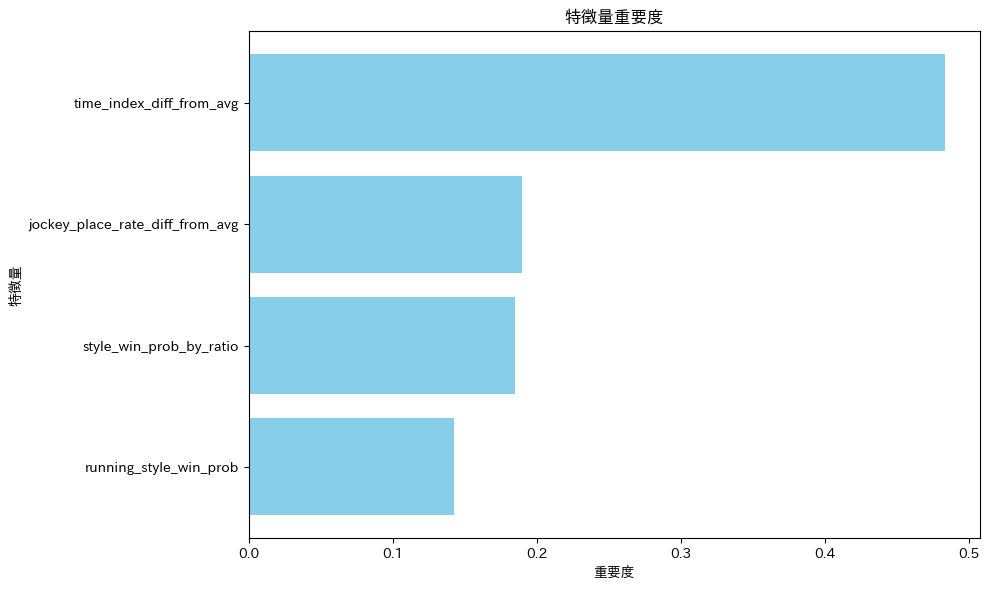

✅ 推論完了

▼ モデル1 的中率: 69.17%（415/600）

📊 人気別的中率・支払額・払戻額・回収率（欠損人気も0で表示）
    popularity  total_pred  hits  accuracy  total_bet  total_payout       roi
0            1          45    22  0.488889       4500        3420.0      0.76
1            2          26     3  0.115385       2600        1010.0  0.388462
2            3           9     0       0.0        900           0.0       0.0
3            4           9     0       0.0        900           0.0       0.0
4            5           3     0       0.0        300           0.0       0.0
5            6           3     0       0.0        300           0.0       0.0
6            7           1     0       0.0        100           0.0       0.0
7            8           2     0       0.0        200           0.0       0.0
8            9           1     0       0.0        100           0.0       0.0
9           10           0     0      <NA>          0           0.0      <NA>
10          11           1     0       0.0        100           0.0      

In [15]:
import matplotlib.pyplot as plt

# ===============================================================
# 特徴量リスト
# ===============================================================
features = [
    "time_index_diff_from_avg",
    "jockey_place_rate_diff_from_avg",
#    "win_rate_by_course_horse_number",
    "running_style_win_prob",
    "style_win_prob_by_ratio",
    # ここから相互作用項
#    "time_index_diff_from_avg_and_jockey_place_rate_diff_from_avg",
#    "time_index_diff_from_avg_and_win_rate_by_course_horse_number",
#    "time_index_diff_from_avg_and_running_style_win_prob",
#    "time_index_diff_from_avg_and_style_win_prob_by_ratio",
#    "jockey_place_rate_diff_from_avg_and_win_rate_by_course_horse_number",
#    "jockey_place_rate_diff_from_avg_and_running_style_win_prob",
#    "jockey_place_rate_diff_from_avg_and_style_win_prob_by_ratio",
#    "win_rate_by_course_horse_number_and_running_style_win_prob",
#    "win_rate_by_course_horse_number_and_style_win_prob_by_ratio",
#    "running_style_win_prob_and_style_win_prob_by_ratio",
]

# ===============================================================
# ラベル作成
# ===============================================================
df_target["is_top4"] = (
    df_target.groupby("race_id")["finish_rank"]
    .rank(method="first") <= df_target["num_horses"] / 2
).astype(int)

# ===============================================================
# 学習用フィルタ
# ===============================================================
valid_year = 2024
train_year = valid_year - 1
filtered_df = df_target[
    (df_target["race_date"].dt.year >= train_year) &
    (df_target["race_date"].dt.year <= valid_year)
].copy()

# ===============================================================
# XGBoost モデル
# ===============================================================
df_m1 = filtered_df.copy()
X_m1 = df_m1[features]
y_m1 = df_m1["is_top4"]

# --- 人気フィルタ設定（学習データのみ）---
exclude_popularities = [1]
#train_mask = (df_m1["race_date"].dt.year == train_year)
train_mask = (df_m1["race_date"].dt.year == train_year) & (~df_m1["popularity"].isin(exclude_popularities))
val_mask   = (df_m1["race_date"].dt.year == valid_year)

X_train_m1 = X_m1[train_mask]
y_train_m1 = y_m1[train_mask]
X_val_m1   = X_m1[val_mask]
y_val_m1   = y_m1[val_mask]

model1 = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42,
    subsample=0.8,
    colsample_bytree=0.8,
    base_score=0.5,
    max_depth=3,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0,
)

# 人気に応じた重み設定
# 例: 人気1は重み0.5、人気12は重み2.0 のように補正
df_m1["sample_weight"] = np.interp(df_m1["popularity"], 
                                   (1, num_horses), 
                                   (0.5, 2.0))
# sample_weightなし
# model1.fit(X_train_m1, y_train_m1)
# sample_weightあり
model1.fit(X_train_m1, y_train_m1, sample_weight=df_m1.loc[train_mask, "sample_weight"])

# ===============================================================
# 特徴量重要度の出力
# ===============================================================
# 特徴量重要度をDataFrame化
importance_df = pd.DataFrame({
    "feature": features,
    "importance": model1.feature_importances_
}).sort_values("importance", ascending=False)

print("\n🌟 特徴量重要度ランキング（上位）")
print(importance_df.head(20))

# CSV出力
# importance_csv_path = f"C:\\Users\\ryo\\Downloads\\feature_importance_{target_course_id}_{num_horses}_{valid_year}.csv"
# importance_df.to_csv(importance_csv_path, index=False, encoding="utf-8-sig")
# print(f"💾 特徴量重要度をCSV出力しました: {importance_csv_path}")

# グラフ出力
plt.figure(figsize=(10, 6))
plt.barh(importance_df["feature"], importance_df["importance"], color="skyblue")
plt.xlabel("重要度")
plt.ylabel("特徴量")
plt.title("特徴量重要度")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ===============================================================
# 推論
# ===============================================================
df_test = filtered_df[filtered_df["race_date"].dt.year == valid_year].copy()
full_predictions = []

for race_id, group in df_test.groupby("race_id"):
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1["pred_prob_m1"] = model1.predict_proba(X_test_m1)[:, 1]
    group_m1 = group_m1.sort_values("pred_prob_m1", ascending=False)
    group_m1["selected_in_m1"] = 0
    num = int(num_horses / 2)
    group_m1.iloc[:num, group_m1.columns.get_loc("selected_in_m1")] = 1
    full_predictions.append(group_m1)

full_pred_df = pd.concat(full_predictions, ignore_index=True)
print("✅ 推論完了")

# ===============================================================
# 結果評価
# ===============================================================
m1_preds = full_pred_df[full_pred_df["selected_in_m1"] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds["finish_rank"] <= num_horses / 2).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0
print(f"\n▼ モデル1 的中率: {m1_accuracy:.2%}（{m1_hits}/{m1_total}）")

# ===============================================================
# 人気別および全体の的中率・回収率・支払額・払戻額
# ===============================================================

# 各レースで「最も勝つ確率が高い馬」を抽出
df_pred_top1 = full_pred_df.loc[
    full_pred_df.groupby("race_id")["pred_prob_m1"].idxmax()
].copy()

# 的中フラグ・払戻金
df_pred_top1["is_hit"] = (df_pred_top1["finish_rank"] == 1).astype(int)
bet_amount = 100
df_pred_top1["payout"] = df_pred_top1["is_hit"] * df_pred_top1["odds"] * bet_amount

# ---- 人気別集計 ----
pop_stats = (
    df_pred_top1.groupby("popularity")
    .agg(
        total_pred=("is_hit", "count"),      # 投票数
        hits=("is_hit", "sum"),              # 的中数
        total_payout=("payout", "sum"),      # 払戻合計
    )
)

# 人気が存在しない順位も0で埋める
pop_stats = pop_stats.reindex(range(1, num_horses + 1), fill_value=0).reset_index()
pop_stats.rename(columns={"index": "popularity"}, inplace=True)

# 追加計算列
pop_stats["total_bet"] = pop_stats["total_pred"] * bet_amount
pop_stats["accuracy"] = pop_stats["hits"] / pop_stats["total_pred"].replace(0, pd.NA)
pop_stats["roi"] = pop_stats["total_payout"] / pop_stats["total_bet"].replace(0, pd.NA)

print("\n📊 人気別的中率・支払額・払戻額・回収率（欠損人気も0で表示）")
print(pop_stats[["popularity", "total_pred", "hits", "accuracy", "total_bet", "total_payout", "roi"]])

# ===============================================================
# ✅ CSV 出力（人気別集計）
# ===============================================================
pop_stats.to_csv(
    f"C:\\Users\\ryo\\Downloads\\popularity_stats_{course_label}_{num_horses}_{valid_year}.csv",
    index=False,
    encoding="utf-8-sig"
)

# ===============================================================
# ✅ 指定人気だけを購入する設定
# ===============================================================
buy_popularities = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# buy_popularities = [5, 6, 7]
# buy_popularities = [3, 4, 5, 6]

df_buy = df_pred_top1[df_pred_top1["popularity"].isin(buy_popularities)].copy()

total_pred_buy = len(df_buy)
total_hits_buy = df_buy["is_hit"].sum()
total_bet_buy = total_pred_buy * bet_amount
total_payout_buy = df_buy["payout"].sum()

accuracy_buy = total_hits_buy / total_pred_buy if total_pred_buy > 0 else 0
roi_buy = total_payout_buy / total_bet_buy if total_pred_buy > 0 else 0

print(f"\n🎯 指定人気 {buy_popularities} の購入結果")
print(f"予想レース数: {total_pred_buy}")
print(f"的中数: {total_hits_buy}")
print(f"支払総額: {total_bet_buy:,}円")
print(f"払戻総額: {total_payout_buy:,.0f}円")
print(f"的中率 (Accuracy): {accuracy_buy:.2%}")
print(f"ROI (回収率): {roi_buy:.2%}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm

# --- 未来リークなしLOESS関数（逐次LOESS） ---
def rolling_loess(y, frac=0.1, window=200):
    """
    過去データのみを使った逐次LOESS（擬似LOESS）を計算する関数。
    """
    n = len(y)
    loess_seq = np.full(n, np.nan)
    for i in tqdm(range(n), desc="逐次LOESS計算中"):
        start = max(0, i - window)
        end = i + 1
        # i < windowのとき (start, end) = (0, i)
        # i >= windowのとき (start, end) = (i - window, i)
        y_sub = y[start:end]
        x_sub = np.arange(len(y_sub))
        if len(y_sub) < 5:
            loess_seq[i] = y_sub[i]
            continue
        # y_sub, x_subをプロットした際のなめらかな曲線を返す
        smoothed = lowess(y_sub, x_sub, frac=frac, return_sorted=False)
        loess_seq[i] = smoothed[-1]
    return loess_seq

# パラメータ
target_popularity =1
N_short = 20
N_long = 100
EMA_SPAN = 20
frac = 1.0
window = 200

# --- 対象人気を指定 ---
df_plot = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()
df_plot['is_win'] = (df_plot['finish_rank'] == 1).astype(int)

# --- p100 / pN 計算 ---
df_plot['pN_short'] = df_plot['is_win'].rolling(N_short, min_periods=1).mean().shift(1)
df_plot['pN_long'] = df_plot['is_win'].rolling(N_long, min_periods=1).mean().shift(1)

# --- 移動平均 (SMA) ---
df_plot['SMA_short'] = df_plot['pN_short'].rolling(N_short, min_periods=1).mean()
df_plot['SMA_long'] = df_plot['pN_long'].rolling(N_long, min_periods=1).mean()

# --- 指数移動平均 (EMA) ---
# df_plot['pN_EMA'] = df_plot['pN'].ewm(span=EMA_SPAN, adjust=False).mean()

# --- 移動中央値 ---
# df_plot['pN_median'] = df_plot['pN'].rolling(N, min_periods=1).median()

# --- 通常LOESS（全データ使用・リークあり） ---
# df_plot['pN_LOESS_leaky'] = lowess(df_plot['pN'], np.arange(len(df_plot)), frac=frac, return_sorted=False)

# --- 未来リークなしLOESS（擬似LOESS） ---
# df_plot['pN_LOESS_no_leak'] = rolling_loess(df_plot['pN'].values, frac=frac, window=window)
# df_plot['pN_LOESS_no_leak_2'] = rolling_loess(df_plot['pN_LOESS_no_leak'].values, frac=frac, window=window)
# df_plot['pN_LOESS_no_leak_3'] = rolling_loess(df_plot['pN_SMA'].values, frac=frac, window=window)

# --- グラフ作成 ---
plt.figure(figsize=(16, 6))
x = np.arange(len(df_plot))

plt.plot(x, df_plot['pN_short'], label='pN_short', color='black', alpha=0.4)
plt.plot(x, df_plot['pN_long'], label='pN_long', color='blue', alpha=0.4)
plt.plot(x, df_plot['SMA_short'], label='SMA_short', color='orange', linewidth=1.2)
plt.plot(x, df_plot['SMA_long'], label='SMA_long', color='red', linewidth=1.2)
# plt.plot(x, df_plot['pN_EMA'], label='EMA', color='green', linewidth=1.2)
# plt.plot(x, df_plot['pN_median'], label='移動中央値', color='purple', linewidth=1.2)
# plt.plot(x, df_plot['pN_LOESS_leaky'], label='LOESS（全期間・未来リークあり）', color='red', linestyle='--')
# plt.plot(x, df_plot['pN_LOESS_no_leak'], label='逐次LOESS（未来リークなし）', color='black', linewidth=2)
# plt.plot(x, df_plot['pN_LOESS_no_leak_2'], label='逐次LOESS2（未来リークなし）', color='red', linewidth=2)
# plt.plot(x, df_plot['pN_LOESS_no_leak_3'], label='逐次LOESS3（未来リークなし）', color='purple', linewidth=2)

# 横軸の目盛りは一定間隔
step = max(1, len(x)//10)
plt.xticks(ticks=np.arange(0, len(x), step))

plt.xlabel('レース連番')
plt.ylabel('発生率')
plt.title(f'人気{target_popularity}の p{N} と各種平滑化曲線の比較（LOESSリーク確認用）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm

# --- パラメータ設定 ---
N = 50           # 直近過去Nレースで的中率を算出
SMA_N = 50       # 移動平均の期間
target_popularity = 1   # 対象人気
valid_year = 2024       # 検証対象年
threshold = 0.3         # 確率の閾値（この値以上なら1着予想とみなす）

# --- データ準備 ---
df_hit = full_pred_df.copy()

# 検証対象年でフィルタ
df_hit = df_hit[df_hit['race_date'].dt.year == valid_year].copy()

# --- 予測の判定 ---
# モデルの出力確率 pred_prob_m1 が threshold を超えたら「1着予想」とする
df_hit['predict_win'] = (df_hit['pred_prob_m1'] >= threshold).astype(int)

# 実際に1着になったか
df_hit['is_win'] = (df_hit['finish_rank'] == 1).astype(int)

# --- 的中判定 ---
# 「1着予想」かつ「実際に1着」なら的中
df_hit['is_hit'] = ((df_hit['predict_win'] == 1) & (df_hit['is_win'] == 1)).astype(int)

# --- 対象人気を指定 ---
df_plot = df_hit[df_hit['popularity'] == target_popularity].copy()
df_plot = df_plot.sort_values(by='race_date').reset_index(drop=True)

# --- pN（的中率）の計算 ---
df_plot['pN'] = df_plot['is_hit'].rolling(N, min_periods=1).mean().shift(1)

# --- 平滑化（移動平均: SMA） ---
df_plot['SMA'] = df_plot['pN'].rolling(SMA_N, min_periods=1).mean()

# --- グラフ作成 ---
plt.figure(figsize=(16, 6))
x = np.arange(len(df_plot))

plt.plot(x, df_plot['pN'], label=f'p{N}（的中率）', color='black', alpha=0.6)
plt.plot(x, df_plot['SMA'], label=f'SMA{SMA_N}（移動平均）', color='red', linewidth=1.5)

# 軸ラベル・タイトル設定
step = max(1, len(x)//10)
plt.xticks(ticks=np.arange(0, len(x), step))

plt.xlabel('レース連番', fontsize=12)
plt.ylabel('的中率', fontsize=12)
plt.title(f'人気{target_popularity}の「確率>{threshold}」予想における的中率推移（p{N}・SMA{SMA_N}）', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- シミュレーション関数 ---
def simulate_single_popularity(
    df,
    target_popularity=1,
    calc_threshold=0.5,  # 的中率を計算するための閾値
    buy_threshold=0.8,   # 購入判断のための閾値
    N_short=100,
    N_long=100,
    N_SMA_short=100,
    N_SMA_long=100,
    pN_threshold=0.2,
    bet_amount=100,
    min_odds=1.1,
    max_odds=1000,
    buy_mode="slope",
    confidence=0.9,
    exclude_initial_N=True
):
    """
    指定人気の馬について、
    「的中率を算出するための閾値」と「購入の判断を行う閾値」を分離して
    シミュレーションを行う。

    exclude_initial_N=True の場合、
    最初の N_short レースは的中率が安定していないため購入対象外にする。
    """

    # --- 対象データ抽出 ---
    df_pop = df[df['popularity'] == target_popularity].copy()
    df_pop = df_pop.sort_values(by='race_date').reset_index(drop=True)
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- 的中率算出用の的中定義 ---
    df_pop['predict_win_calc'] = (df_pop['pred_prob_m1'] >= calc_threshold).astype(int)
    df_pop['is_hit_calc'] = ((df_pop['predict_win_calc'] == 1) & (df_pop['is_win'] == 1)).astype(int)

    # --- pN, SMA 計算 ---
    df_pop['pN_short'] = df_pop['is_hit_calc'].rolling(N_short, min_periods=1).mean().shift(1)
    df_pop['pN_long']  = df_pop['is_hit_calc'].rolling(N_long,  min_periods=1).mean().shift(1)
    df_pop['SMA_short'] = df_pop['pN_short'].rolling(N_SMA_short, min_periods=1).mean()
    df_pop['SMA_long']  = df_pop['pN_long'].rolling(N_SMA_long,  min_periods=1).mean()
    df_pop['SMA_short_slope'] = df_pop['SMA_short'].diff()
    df_pop['SMA_long_slope']  = df_pop['SMA_long'].diff()

    # --- 購入条件定義 ---
    if buy_mode == "none":
        df_pop['cond'] = (df_pop['pred_prob_m1'] >= buy_threshold)
    elif buy_mode == "slope":
        df_pop['cond'] = (
            (df_pop['SMA_short_slope'] > 0) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "SMA_SMA_cross":
        df_pop['cond'] = (
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "pN_SMA_short_cross":
        df_pop['cond'] = (
            (df_pop['pN_short'] > df_pop['SMA_short']) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "pN_SMA_short_cross_th":
        df_pop['cond'] = (
            (df_pop['pN_short'] > df_pop['SMA_short']) &
            (df_pop['pN_short'] > pN_threshold) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "pN_SMA_short_cross_slope_th":
        df_pop['cond'] = (
            (df_pop['pN_short'] > df_pop['SMA_short']) &
            (df_pop['pN_short'] > pN_threshold) &
            (df_pop['SMA_short_slope'] > 0) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    elif buy_mode == "slope_cross":
        df_pop['cond'] = (
            (df_pop['SMA_long_slope'] > 0) &
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= buy_threshold)
        )
    else:
        raise ValueError("存在しない cond が指定されました。")

    # --- ★最初のNレースを除外 ---
    if exclude_initial_N:
        df_pop.loc[:N_short-1, 'cond'] = False

    # --- 購入データ抽出 ---
    bets = df_pop[df_pop['cond']].copy()
    bets = bets[(bets['odds'] >= min_odds) & (bets['odds'] <= max_odds)]

    df_pop.to_csv('C:\\Users\\ryo\\Downloads\\df_pop.csv', index=False, encoding='cp932')
    
    total_bets = len(bets)
    total_spent = total_bets * bet_amount
    wins = bets['is_win'].sum()

    # --- 結果計算 ---
    if total_bets == 0:
        print("⚠ 該当する購入データがありません。")
        return None, df_pop

    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    total_payout = bets['payout_each'].sum()
    roi = total_payout / total_spent if total_spent > 0 else 0

    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    ci_lower, ci_upper = confidence_interval(roi, std, total_bets, confidence)

    result = {
        'popularity': target_popularity,
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'spent': total_spent,
        'payout': total_payout
    }

    # --- 結果表示 ---
    print("\n============================")
    print(f"🎯 人気{target_popularity} のシミュレーション結果（mode={buy_mode}）")
    print("============================")
    print(f"的中率算出閾値(calc_threshold): {calc_threshold}")
    print(f"購入判定閾値(buy_threshold): {buy_threshold}")
    print(f"最初のN({N_short})件除外: {exclude_initial_N}")
    print("----------------------------")
    print(f"購入数: {total_bets}")
    print(f"的中数: {wins}")
    print(f"的中率: {accuracy:.3f}（{accuracy:.1%}）")
    print(f"回収率: {roi:.3f}（{roi:.1%}）")
    print(f"ROI信頼区間({confidence*100:.0f}%): [{ci_lower:.3f}, {ci_upper:.3f}]")

    # --- グラフ出力 ---
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(df_pop.index, df_pop['pN_short'], color='black', alpha=0.6, label=f'pN({N_short})')
    ax1.plot(df_pop.index, df_pop['pN_long'], color='gray', alpha=0.4, label=f'pN({N_long})')
    ax1.plot(df_pop.index, df_pop['SMA_short'], color='blue', label=f'SMA({N_SMA_short})')
    ax1.plot(df_pop.index, df_pop['SMA_long'], color='orange', label=f'SMA({N_SMA_long})')
    ax1.set_title(
        f"人気{target_popularity} の的中率トレンド\n"
        f"(calc_th={calc_threshold}, buy_th={buy_threshold}, mode={buy_mode})"
    )
    ax1.set_xlabel("レース連番（時系列順）")
    ax1.set_ylabel("的中率 / SMA 値")
    ax1.grid(alpha=0.3)

    # --- 購入点と的中点をマーカーで可視化 ---
    y_buy = -0.03
    y_hit = -0.06
    buy_points = df_pop[df_pop['cond']]
    hit_points = buy_points[buy_points['is_win'] == 1]
    ax1.scatter(buy_points.index, [y_buy]*len(buy_points),
                color='red', marker='|', s=100, label='購入')
    ax1.scatter(hit_points.index, [y_hit]*len(hit_points),
                color='blue', marker='|', s=100, label='的中')

    ax1.legend(loc='upper right')
    ax1.set_ylim(-0.1, 1.0)
    plt.tight_layout()
    plt.show()

    return result, df_pop

result, df_sim = simulate_single_popularity(
    df=full_pred_df,
    target_popularity=1,
    calc_threshold=0.0,
    buy_threshold=0.0,
    N_short=50,
    N_long=50,
    N_SMA_short=50,
    N_SMA_long=100,
    min_odds=1.5,
    max_odds=1.5,
    pN_threshold=0.0,
    buy_mode="none",
    exclude_initial_N=True,
)
'''
result, df_sim = simulate_single_popularity(
    df=full_pred_df,
    target_popularity=2,
    calc_threshold=0.5,
    buy_threshold=0.75,
    N_short=100,
    N_long=100,
    N_SMA_short=10,
    N_SMA_long=100,
    pN_threshold=0.2,
    buy_mode="pN_SMA_short_cross_th",
    exclude_initial_N=True,
)
'''

In [ ]:
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- パラメータ ---
N = 20
bet_amount = 100
EMA_SPAN = 10
prob_threshold = 0.5
frac = 1.0
window = 200
min_odds = 1.1
max_odds = 10000
interp_factor = 10

# --- シミュレーション関数 ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None):
    if cond_col is not None:
        if isinstance(cond_col, str):
            bets = df[df[cond_col]].copy()
        else:
            # cond_colがSeriesならそのまま使う
            bets = df[cond_col].copy()
    else:
        bets = df.copy()
    
    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    total_spent = total_bets * bet_amount

    if total_bets == 0:
        return {
            'bets': 0, 'wins': 0, 'accuracy': 0,
            'roi': 0, 'payout': 0, 'spent': 0,
            'ci': (np.nan, np.nan)
        }

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    payout = bets['payout_each'].sum()
    roi = payout / total_spent if total_spent > 0 else 0
    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'payout': payout,
        'spent': total_spent,
        'ci': (lower, upper)
    }

# --- 逐次LOESS計算（fillnaオプション & skip_initialオプション付き） ---
def compute_sequential_loess(df, points_name, frac, window, fillna_option=None, skip_initial=0):
    
    # fillnaオプション処理
    if fillna_option is not None:
        df[points_name] = df[points_name].fillna(fillna_option)
    
    loess_seq = []
    for i in range(len(df)):
        if i < skip_initial:
            loess_seq.append(np.nan)
            continue

        start_idx = max(skip_initial, i - window)
        end_idx = i + 1
        if end_idx - start_idx < 2:
            loess_seq.append(df[points_name].iloc[i])
            continue
        smoothed = lowess(df[points_name].iloc[start_idx:end_idx], 
                          np.arange(end_idx - start_idx), frac=frac, return_sorted=False)
        loess_seq.append(smoothed[-1])
        
    df['loess_seq'] = loess_seq
    df['loess_seq_slope'] = np.diff(df['loess_seq'], prepend=np.nan)
    df['loess_seq_slope2'] = np.diff(df['loess_seq_slope'], prepend=np.nan)
    # df['loess_seq_slope'] = np.gradient(df['loess_seq'], edge_order=2)
    # df['loess_seq_slope2'] = np.gradient(df['loess_seq_slope'], edge_order=2)
    
    return df

def compute_sequential_loess_smooth(df, N=100, frac=0.1, window=200, interp_factor=5, skip_initial=0, fillna_option=None):
    df = df.copy()
    df['pN'] = df['is_win'].rolling(N, min_periods=1).mean().shift(1)
    
    if fillna_option is not None:
        df['pN'] = df['pN'].fillna(fillna_option)
    
    loess_seq = []
    loess_slope = []
    loess_slope2 = []

    for i in range(len(df)):
        if i < skip_initial:
            loess_seq.append(np.nan)
            loess_slope.append(np.nan)
            loess_slope2.append(np.nan)
            continue

        start_idx = max(skip_initial, i - window)
        end_idx = i + 1
        if end_idx - start_idx < 2:
            loess_seq.append(df['pN'].iloc[i])
            loess_slope.append(np.nan)
            loess_slope2.append(np.nan)
            continue

        x = np.arange(end_idx - start_idx)
        y = df['pN'].iloc[start_idx:end_idx].values

        # NaN除去
        mask = ~np.isnan(y)
        x = x[mask]
        y = y[mask]
        if len(x) < 2:
            loess_seq.append(np.nan)
            loess_slope.append(np.nan)
            loess_slope2.append(np.nan)
            continue

        smoothed = lowess(y, x, frac=frac, return_sorted=False)

        # 補間方法を切り替え
        kind = 'cubic' if len(x) >= 4 else 'linear'
        interp_x = np.linspace(x.min(), x.max(), len(x) * interp_factor)
        f_interp = interp1d(x, smoothed, kind=kind, fill_value='extrapolate')
        dense_y = f_interp(interp_x)

        dx = interp_x[1] - interp_x[0]
        slope = np.gradient(dense_y, dx)
        slope2 = np.gradient(slope, dx)

        loess_seq.append(dense_y[-1])
        loess_slope.append(slope[-1])
        loess_slope2.append(slope2[-1])

    df['loess_seq'] = loess_seq
    df['loess_seq_slope'] = loess_slope
    df['loess_seq_slope2'] = loess_slope2

    return df

# --- 条件定義 ---
conditions = {
    '09': lambda df: df['loess_seq_slope'] > 0,
    '10': lambda df: (df['loess_seq_slope'] > 0) & (df['pN'] < df['loess_seq']),
    '11': lambda df: (df['loess_seq_slope'].shift(2) > 0) & (df['loess_seq_slope2'].shift(2) > 0),
    '12': lambda df: (df['loess_seq_slope'].shift(1) > 0) & (df['loess_seq_slope2'].shift(2) > 0),   
    '13': lambda df: df['loess_seq_slope'] > 0,
    '14': lambda df: df['loess_seq_slope2'] > 0,
    '15': lambda df: (df['pN'] > df['loess_seq']) & (df['loess_seq_slope'] > 0),
    '16': lambda df: (df['pN'] > df['loess_seq']),
    '17': lambda df: (df['loess_seq_slope'] > 0) & (df['loess_seq_slope2'] > 0),
    '18': lambda df: (df['loess_seq_slope'] > 0) & (df['loess_seq_slope2'] < 0)
}

# --- ここでどれを計算するか指定 ---
target_cond = '13' # conditionsで定義されているどれか
fillna_option = None  # None または 0 など
skip_initial = N    # 最初の N 行を無視（0またはNにする）

print("\n" + "="*30)
print(f"🎯 条件 {target_cond} 人気ごとシミュレーション")
print("="*30)

results_all = []
all_bets_df = []

for pop in sorted(full_pred_df['popularity'].unique()):

    print(f'人気：{pop}を処理中')
    
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- 1回目の逐次LOESS ---
    df_pop['pN'] = df_pop['is_win'].rolling(N, min_periods=1).mean().shift(1)
    df_pop = compute_sequential_loess(df_pop, 'pN', frac, window, fillna_option, skip_initial)

    # --- 2回目の逐次LOESS（loess_seqをもとに再平滑化）---
    # 1回目で得られた loess_seq を "is_win" の代わりに使って2段階目を実施
    df_pop_for_second = df_pop.copy()
    df_pop = compute_sequential_loess(df_pop_for_second, 'loess_seq', frac, window, fillna_option, skip_initial)

    # （必要なら loess_seq_2 など別名で保持したい場合）
    # df_pop['loess_seq_2'] = df_pop['loess_seq']
    # df_pop.drop(columns=['loess_seq_slope', 'loess_seq_slope2'], inplace=True)
    # df_pop.rename(columns={'loess_seq': 'loess_seq_2',
    #                        'loess_seq_slope': 'loess_seq_slope_2',
    #                        'loess_seq_slope2': 'loess_seq_slope2_2'}, inplace=True)

    # --- 条件判定 ---
    
    df_pop['cond'] = conditions[target_cond](df_pop) & (df_pop['pred_prob_m1'] >= prob_threshold)

    # --- シミュレーション ---
    res = simulate_hits(df_pop, 'cond', min_odds, max_odds)

    results_all.append({
        'popularity': pop,
        'bets': res['bets'],
        'wins': res['wins'],
        'spent': res['spent'],
        'payout': res['payout'],
        'accuracy': res['accuracy'],
        'roi': res['roi'],
        'ci_lower': res['ci'][0],
        'ci_upper': res['ci'][1]
    })

    all_bets_df.append(df_pop[df_pop['cond']])

    # CSV出力
    df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\df_pop_{target_cond}_{pop}.csv',index=False, encoding='cp932')

df_all_bets = pd.concat(all_bets_df, ignore_index=True)
res_total = simulate_hits(df_all_bets, None, min_odds, max_odds)

df_result = pd.DataFrame(results_all)
df_result['accuracy_pct'] = df_result['accuracy'] * 100
df_result['roi_pct'] = df_result['roi'] * 100

# 合計行追加
df_total = pd.DataFrame([{
    'popularity': '合計',
    'bets': res_total['bets'],
    'wins': res_total['wins'],
    'spent': res_total['spent'],
    'payout': res_total['payout'],
    'accuracy': res_total['accuracy'],
    'roi': res_total['roi'],
    'ci_lower': res_total['ci'][0],
    'ci_upper': res_total['ci'][1],
    'accuracy_pct': res_total['accuracy'] * 100,
    'roi_pct': res_total['roi'] * 100
}])
df_result = pd.concat([df_result, df_total], ignore_index=True)

# --- パラメータ出力 ---
print("\n--- パラメータ設定 ---")
print(f"N={N}, bet_amount={bet_amount}, EMA_SPAN={EMA_SPAN}, prob_threshold={prob_threshold}")
print(f"loess_frac={frac}, min_odds={min_odds}, max_odds={max_odds}")
print(f"fillna_option={fillna_option}, skip_initial={skip_initial}\n")

# 出力
print(df_result[['popularity', 'bets', 'wins', 'spent', 'payout', 'accuracy_pct', 'roi_pct']].to_string(
    index=False,
    formatters={
        'accuracy_pct': '{:.2f}'.format,
        'roi_pct': '{:.2f}'.format,
        'spent': '{:,.0f}'.format,
        'payout': '{:,.0f}'.format
    }
))

# CSV出力
df_result.to_csv(f'C:\\Users\\ryo\\Downloads\\loess_seq_{target_cond}_all_popularity.csv',index=False, encoding='cp932')

from tqdm import tqdm
import matplotlib.pyplot as plt

# --- 閾値を変化させてシミュレーション ---
threshold_values = np.linspace(0, 0.005, 21)  # 例: 0～0.005を0.00025刻みで
popularity_results = []

print("\n============================")
print("🎯 閾値スキャン開始")
print("============================")

for pop in tqdm(sorted(full_pred_df['popularity'].unique()), desc="人気別処理"):
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- LOESS処理 ---
    df_pop['pN'] = df_pop['is_win'].rolling(N, min_periods=1).mean().shift(1)
    df_pop = compute_sequential_loess(df_pop, 'pN', frac, window, fillna_option, skip_initial)
    df_pop_for_second = df_pop.copy()
    df_pop = compute_sequential_loess(df_pop_for_second, 'loess_seq', frac, window, fillna_option, skip_initial)

    # --- 閾値スキャン ---
    for thr in threshold_values:
        cond = (df_pop['loess_seq_slope'] > thr) & (df_pop['pred_prob_m1'] >= prob_threshold)
        res = simulate_hits(df_pop, cond_col=cond, min_odds=min_odds, max_odds=max_odds)

        popularity_results.append({
            'popularity': pop,
            'threshold': thr,
            'bets': res['bets'],
            'wins': res['wins'],
            'accuracy': res['accuracy'],
            'roi': res['roi']
        })

        # 進捗をprintでも見たい場合
        print(f"pop={pop:>2}, thr={thr:.5f}, bets={res['bets']:4d}, acc={res['accuracy']:.3f}, ROI={res['roi']:.3f}")

# --- 結果をDataFrame化 ---
df_thr = pd.DataFrame(popularity_results)

# --- グラフ化 ---
plt.style.use('seaborn-v0_8-darkgrid')
unique_pops = sorted(df_thr['popularity'].unique())

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# 的中率グラフ
for pop in unique_pops:
    sub = df_thr[df_thr['popularity'] == pop]
    axes[0].plot(sub['threshold'], sub['accuracy'] * 100, label=f'人気 {pop}')
axes[0].set_ylabel('的中率 (%)')
axes[0].set_title('閾値別 的中率')
axes[0].legend()

# ROIグラフ
for pop in unique_pops:
    sub = df_thr[df_thr['popularity'] == pop]
    axes[1].plot(sub['threshold'], sub['roi'] * 100, label=f'人気 {pop}')
axes[1].set_ylabel('回収率 (%)')
axes[1].set_xlabel('loess_seq_slope 閾値')

plt.suptitle('loess_seq_slope 閾値別パフォーマンス')
plt.tight_layout()
plt.show()

# --- CSV出力 ---
df_thr.to_csv(f'C:\\Users\\ryo\\Downloads\\threshold_scan_{target_cond}.csv', index=False, encoding='cp932')
print("\n✅ 閾値スキャン完了！結果をCSVに保存しました。")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

# --- 信頼区間関数 ---
def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.9):
    if n <= 1 or std == 0:
        return (mean, mean)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    margin = t_value * std / np.sqrt(n)
    return (mean - margin, mean + margin)

# --- シミュレーション関数 ---
def simulate_hits(df, cond_col=None, min_odds=None, max_odds=None, bet_amount=100):
    if cond_col is not None:
        if isinstance(cond_col, str):
            bets = df[df[cond_col]].copy()
        else:
            bets = df[cond_col].copy()
    else:
        bets = df.copy()
    
    if min_odds is not None:
        bets = bets[bets['odds'] >= min_odds]
    if max_odds is not None:
        bets = bets[bets['odds'] <= max_odds]

    total_bets = len(bets)
    total_spent = total_bets * bet_amount

    if total_bets == 0:
        return {
            'bets': 0, 'wins': 0, 'accuracy': 0,
            'roi': 0, 'payout': 0, 'spent': 0,
            'ci': (np.nan, np.nan)
        }

    wins = bets['is_win'].sum()
    accuracy = wins / total_bets
    bets['payout_each'] = bets['is_win'] * bets['odds'] * bet_amount
    payout = bets['payout_each'].sum()
    roi = payout / total_spent if total_spent > 0 else 0
    std = bets['payout_each'].std(ddof=1) if total_bets > 1 else 0
    lower, upper = confidence_interval(roi, std, total_bets)

    return {
        'bets': total_bets,
        'wins': wins,
        'accuracy': accuracy,
        'roi': roi,
        'payout': payout,
        'spent': total_spent,
        'ci': (lower, upper)
    }

# --- パラメータ設定 ---
N_short = 20       # 短期SMA
N_long = 200       # 長期SMA
bet_amount = 100
prob_threshold = 0.7
min_odds = 1.1
max_odds = 10000

# --- 購入モード ---
buy_mode = "slope_cross"   # "slope" または "cross" を指定

print("\n============================")
print(f"🎯 SMAシミュレーション開始（モード: {buy_mode}）")
print("============================")

results_all = []
bets_all = []

for pop in sorted(full_pred_df['popularity'].unique()):

    print(f'人気 {pop} を処理中...')
    
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # --- SMA計算 ---
    df_pop['pN_short'] = df_pop['is_win'].rolling(N_short, min_periods=1).mean().shift(1)
    df_pop['pN_long'] = df_pop['is_win'].rolling(N_long, min_periods=1).mean().shift(1)
    df_pop['SMA_short'] = df_pop['pN_short'].rolling(N_short, min_periods=1).mean()
    df_pop['SMA_long'] = df_pop['pN_long'].rolling(N_long, min_periods=1).mean()
    df_pop['SMA_slope_short'] = df_pop['SMA_short'].diff()
    df_pop['SMA_slope_long'] = df_pop['SMA_long'].diff()

    # --- 購入条件 ---
    if buy_mode == "slope":
        df_pop['cond'] = (df_pop['SMA_slope'] > 0) & (df_pop['pred_prob_m1'] >= prob_threshold)
    elif buy_mode == "dual_slope":
        df_pop['cond'] = (
            (df_pop['SMA_slope_short'] > 0) & 
            (df_pop['SMA_slope_long'] > 0) &
            (df_pop['pred_prob_m1'] >= prob_threshold)
        )
    elif buy_mode == "cross":
        df_pop['cond'] = (
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= prob_threshold)
        )
    elif buy_mode == "slope_cross":
        df_pop['cond'] = (
            (df_pop['SMA_slope_long'] > 0) &
            (df_pop['SMA_short'] > df_pop['SMA_long']) &
            (df_pop['pred_prob_m1'] >= prob_threshold)
        )
    elif buy_mode == "none":
        df_pop['cond'] = True
    else:
        raise ValueError("buy_mode は 'slope' または 'cross' のいずれかを指定してください。")
    
    # --- シミュレーション ---
    res = simulate_hits(df_pop, 'cond', min_odds, max_odds, bet_amount)

    results_all.append({
        'popularity': pop,
        'bets': res['bets'],
        'wins': res['wins'],
        'spent': res['spent'],
        'payout': res['payout'],
        'accuracy': res['accuracy'],
        'roi': res['roi'],
        'ci_lower': res['ci'][0],
        'ci_upper': res['ci'][1]
    })
    bets_all.append(df_pop[df_pop['cond']])
    
    # --- CSV出力 ---
    df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\df_pop_SMA_{buy_mode}_{pop}.csv', index=False, encoding='cp932')
    
    # --- プロット ---
    fig, ax1 = plt.subplots(figsize=(12, 6)) 
    ax1.plot(df_pop.index, df_pop['pN_short'], color='gray', alpha=0.4, label=f'pN({N_short})')
    ax1.plot(df_pop.index, df_pop['SMA_short'], color='blue', label=f'SMA({N_short})')
    ax1.plot(df_pop.index, df_pop['SMA_long'], color='orange', label=f'SMA({N_long})')
    ax1.set_title(f"人気 {pop}（モード: {buy_mode}）のSMAトレンドと購入点")
    ax1.set_xlabel("データ時系列（index）")
    ax1.set_ylabel("勝率 / SMA 値")
    ax1.grid(alpha=0.3)

    # --- 購入点・的中点 ---
    y_buy = -0.02
    y_hit = -0.05
    buy_points = df_pop[df_pop['cond']]
    hit_points = buy_points[buy_points['is_win'] == 1]
    ax1.scatter(buy_points.index, [y_buy]*len(buy_points),
                color='red', marker='|', s=80, label='購入')
    ax1.scatter(hit_points.index, [y_hit]*len(hit_points),
                color='green', marker='|', s=120, label='的中')

    # --- 条件TRUEの塊ごとの的中率をpN_shortの上に表示 ---
    cond_series = df_pop['cond'].astype(int)
    diff = cond_series.diff().fillna(0)
    group_starts = cond_series[diff == 1].index.tolist()
    group_ends = cond_series[diff == -1].index.tolist()
    if cond_series.iloc[0] == 1:
        group_starts = [cond_series.index[0]] + group_starts
    if cond_series.iloc[-1] == 1:
        group_ends = group_ends + [cond_series.index[-1]]

    for start, end in zip(group_starts, group_ends):
        group_df = df_pop.loc[start:end]
        accuracy = group_df['is_win'].sum() / len(group_df)
        x_pos = (start + end) / 2
        y_pos = group_df['pN_short'].max() + 0.02
        ax1.text(x_pos, y_pos, f'{accuracy:.2f}', color='purple', fontsize=5,
                 ha='center', va='bottom', rotation=0)

    # --- 凡例調整 ---
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right')

    # --- y軸範囲調整 ---
    min_y = min(df_pop[['pN_short','SMA_short','SMA_long']].min().min(), -0.1)
    ax1.set_ylim(min_y - 0.1, 1.0)

    # --- 保存 ---
    plt.tight_layout()
    plt.savefig(f"C:\\Users\\ryo\\Downloads\\plot_SMA_{buy_mode}_{pop}.png", dpi=200)
    plt.close()

# --- 人気ごとの結果集計 ---
df_all_bets = pd.concat(bets_all, ignore_index=True)
res_total = simulate_hits(df_all_bets, None, min_odds, max_odds, bet_amount)

df_result = pd.DataFrame(results_all)
df_result['accuracy_pct'] = df_result['accuracy'] * 100
df_result['roi_pct'] = df_result['roi'] * 100

df_total = pd.DataFrame([{
    'popularity': '合計',
    'bets': res_total['bets'],
    'wins': res_total['wins'],
    'spent': res_total['spent'],
    'payout': res_total['payout'],
    'accuracy': res_total['accuracy'],
    'roi': res_total['roi'],
    'ci_lower': res_total['ci'][0],
    'ci_upper': res_total['ci'][1],
    'accuracy_pct': res_total['accuracy'] * 100,
    'roi_pct': res_total['roi'] * 100
}])

df_result = pd.concat([df_result, df_total], ignore_index=True)

# --- 出力 ---
print("\n--- パラメータ設定 ---")
print(f"N_short={N_short}, N_long={N_long}, bet_amount={bet_amount}, prob_threshold={prob_threshold}")
print(f"min_odds={min_odds}, max_odds={max_odds}, mode={buy_mode}\n")

print(df_result[['popularity', 'bets', 'wins', 'spent', 'payout', 'accuracy_pct', 'roi_pct']].to_string(
    index=False,
    formatters={
        'accuracy_pct': '{:.2f}'.format,
        'roi_pct': '{:.2f}'.format,
        'spent': '{:,.0f}'.format,
        'payout': '{:,.0f}'.format
    }
))

# --- 保存 ---
df_result.to_csv(f'C:\\Users\\ryo\\Downloads\\SMA_simulation_results_{buy_mode}.csv',
                 index=False, encoding='cp932')

print(f"\n✅ SMAベースのシミュレーション完了！（モード: {buy_mode}）")


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from tqdm import tqdm  # 進捗表示用

# --- パラメータ設定 ---
popularities = sorted(full_pred_df['popularity'].unique())  # すべての人気
N = 100               # ローリングウィンドウサイズ
prob_threshold = 0.5  # 予測確率閾値
min_odds = 1.1
max_odds = 10000
bet_amount = 100
loess_frac = 0.1      # LOESSスムージング範囲
skip_initial = N      # 最初の N 行はスキップ

# --- 全人気の結果記録 ---
all_bets = []

for target_pop in popularities:
    print(f"\n--- 人気 {target_pop} 処理中 ---")

    # データ抽出
    df = full_pred_df[full_pred_df['popularity'] == target_pop].copy()
    df = df.sort_values('race_date').reset_index(drop=True)
    df['is_win'] = (df['finish_rank'] == 1).astype(int)

    # --- 逐次LOESS計算 ---
    records = []
    for i in tqdm(range(len(df)), desc=f"人気{target_pop} 逐次LOESS計算"):
        if i < skip_initial:
            records.append({'loess': np.nan, 'slope': np.nan, 'slope2': np.nan})
            continue

        start_idx = max(skip_initial, i - int(loess_frac * len(df)))
        end_idx = i  # 現在行は含めない
        past = df.iloc[start_idx:end_idx].copy()

        past['pN'] = past['is_win'].rolling(N, min_periods=1).mean()

        if len(past) >= 3:
            smoothed = lowess(past['pN'], np.arange(len(past)), frac=1.0, return_sorted=False)
            slope = np.gradient(smoothed, edge_order=2)
            slope2 = np.gradient(slope, edge_order=2)
            loess_last = smoothed[-1]
            slope_last = slope[-1]
            slope2_last = slope2[-1]
        else:
            loess_last = slope_last = slope2_last = np.nan

        records.append({'loess': loess_last, 'slope': slope_last, 'slope2': slope2_last})

    loess_df = pd.DataFrame(records)
    df = pd.concat([df, loess_df], axis=1)

    # --- 購入判定 ---
    df['buy_flag'] = (
        (df['slope'] > 0) &
        (df['slope2'] > 0) &
        (df['pred_prob_m1'] >= prob_threshold) &
        (df['odds'] >= min_odds) &
        (df['odds'] <= max_odds)
    )

    df_bets = df[df['buy_flag']].copy()
    df_bets['payout'] = df_bets['is_win'] * df_bets['odds'] * bet_amount
    df_bets['spent'] = bet_amount
    df_bets['roi'] = (df_bets['payout'] - df_bets['spent']) / df_bets['spent']
    df_bets['popularity'] = target_pop  # 人気情報を保持

    total_bet = df_bets['spent'].sum()
    total_payout = df_bets['payout'].sum()
    roi = total_payout / total_bet if total_bet > 0 else 0
    accuracy = df_bets['is_win'].mean() if len(df_bets) > 0 else 0

    print(f"購入数: {len(df_bets)}, 的中率: {accuracy:.4f} ({accuracy:.2%}), ROI: {roi:.4f} ({roi:.2%})")

    all_bets.append(df_bets)

# --- 全人気をまとめる ---
all_bets_df = pd.concat(all_bets, axis=0)

# CSV出力（必要なら）
all_bets_df.to_csv(
    'C:\\Users\\ryo\\Downloads\\sequential_loess_all_pops.csv',
    index=False, encoding='cp932'
)


In [ ]:
# 人気ごと詳細CSV出力
for pop in sorted(full_pred_df['popularity'].unique()):
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    df_pop['is_win'] = (df_pop['finish_rank'] == 1).astype(int)

    # 逐次LOESS計算
    df_pop = compute_sequential_loess(df_pop, loess_frac, fillna_option, skip_initial)

    # 各条件列 09,10,11
    for cond_key, cond_func in conditions.items():
        df_pop[f'cond_{cond_key}'] = cond_func(df_pop) & (df_pop['pred_prob_m1'] >= prob_threshold)
        df_pop[f'purchase_{cond_key}'] = df_pop[f'cond_{cond_key}'].astype(int)
    
    # 購入時の勝敗とオッズ
    for cond_key in ['09','10','11']:
        df_pop[f'result_{cond_key}'] = df_pop[f'purchase_{cond_key}'] * df_pop['is_win']
        df_pop[f'odds_{cond_key}'] = df_pop['odds'] * df_pop[f'purchase_{cond_key}']

    # 必要な列を選択
    columns_to_save = list(df_pop.columns)  # 元データの全列＋計算列
    # CSV出力
    df_pop.to_csv(f'C:\\Users\\ryo\\Downloads\\detail_pop_{pop}.csv',
                  index=False, encoding='cp932')
